## Setup

`alldat` contains 39 sessions from 10 mice, data from Steinmetz et al, 2019. Time bins for all measurements are 10ms, starting 500ms before stimulus onset. The mouse had to determine which side has the highest contrast. For each `dat = alldat[k]`, you have the following fields:

* `dat['mouse_name']`: mouse name
* `dat['date_exp']`: when a session was performed
* `dat['spks']`: neurons by trials by time bins.    
* `dat['brain_area']`: brain area for each neuron recorded. 
* `dat['contrast_right']`: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
* `dat['contrast_left']`: contrast level for left stimulus. 
* `dat['gocue']`: when the go cue sound was played. 
* `dat['response_times']`: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.  
* `dat['response']`: which side the response was (`-1`, `0`, `1`). When the right-side stimulus had higher contrast, the correct choice was `-1`. `0` is a no go response. 
* `dat['feedback_time']`: when feedback was provided. 
* `dat['feedback_type']`: if the feedback was positive (`+1`, reward) or negative (`-1`, white noise burst).  
* `dat['wheel']`: exact position of the wheel that the mice uses to make a response, binned at `10ms`. 
* `dat['pupil']`: pupil area  (noisy, because pupil is very small) + pupil horizontal and vertical position. 
* `dat['lfp']`: recording of the local field potential in each brain area from this experiment, binned at `10ms`.
* `dat['brain_area_lfp']`: brain area names for the LFP channels. 
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons". 
* `dat['waveform_w']`: temporal components of spike waveforms. `w@u` reconstructs the time by channels action potential shape. 
* `dat['waveform_u]`: spatial components of spike waveforms.
* `dat['%X%_passive']`: same as above for `X` = {`spks`, `lfp`, `pupil`, `wheel`, `contrast_left`, `contrast_right`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses. 

variables of interest:
- spks 
- waveform_w, waveform_u, trough_to_peak, 

In [4]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =20
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

## Load all data and store trial data as a dataframe

In [5]:
alldat = np.array([])

for j in range(1,4):
    alldat = np.hstack((alldat, np.load('data/steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

In [10]:
# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx. 
dat = alldat[11]
print(dat.keys())

dict_keys(['spks', 'wheel', 'pupil', 'lfp', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'brain_area_lfp', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'waveform_w', 'waveform_u', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'lfp_passive', 'pupil_passive', 'wheel_passive'])


In [11]:
# Take a look
for key in dat.keys():
    print(key, np.array(dat[key]).shape)

spks (698, 340, 250)
wheel (1, 340, 250)
pupil (3, 340, 250)
lfp (12, 340, 250)
response (340,)
response_time (340, 1)
bin_size ()
stim_onset ()
contrast_right (340,)
contrast_left (340,)
brain_area (698,)
brain_area_lfp (12,)
feedback_time (340, 1)
feedback_type (340,)
gocue (340, 1)
mouse_name ()
date_exp ()
trough_to_peak (698,)
waveform_w (698, 82, 3)
waveform_u (698, 3, 384)
active_trials (450,)
contrast_left_passive (110,)
contrast_right_passive (110,)
spks_passive (698, 110, 250)
lfp_passive (12, 110, 250)
pupil_passive (3, 110, 250)
wheel_passive (1, 110, 250)


## Filter trials with contrast levels

In [164]:
go = ~np.logical_and(dat['contrast_right'] == 0, dat['contrast_left'] == 0)

contrast_left = dat['contrast_left']
contrast_right = dat['contrast_right']

response =  np.abs(dat['response']) == 1 
contrast_diff_response = np.abs(contrast_left - contrast_right)*response.astype(int)*go.astype(int) 

one_trials = contrast_diff_response == 1
easy_trials = contrast_diff_response == 0.75
medium_trials = contrast_diff_response == 0.5
difficult_trials = contrast_diff_response == 0.25
zero_trials = contrast_diff_response == 0

print(len(contrast_diff_response))
print(sum(one_trials), sum(easy_trials) + sum(zero_trials) + sum(medium_trials) + sum(difficult_trials))
print(sum(one_trials))
print(sum(easy_trials))
print(sum(medium_trials))
print(sum(zero_trials))
print(sum(difficult_trials))

340
43 297
43
44
65
140
48


- no-go out * fossman out 
- fix waveforms 
- fix neurons that don't spike much 
- fix class imbalance (later) 
- time windows 

## Select meaningful neurons

(array([358.,  98.,  44.,  48.,  22.,  20.,  16.,  10.,  17.,  13.,   7.,
          7.,   5.,   5.,   5.,   5.,   2.,   1.,   2.,   2.,   1.,   2.,
          2.,   1.,   0.,   0.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,
          0.,   0.,   1.,   0.,   0.,   1.,   1.]),
 array([    0.  ,  1176.55,  2353.1 ,  3529.65,  4706.2 ,  5882.75,
         7059.3 ,  8235.85,  9412.4 , 10588.95, 11765.5 , 12942.05,
        14118.6 , 15295.15, 16471.7 , 17648.25, 18824.8 , 20001.35,
        21177.9 , 22354.45, 23531.  , 24707.55, 25884.1 , 27060.65,
        28237.2 , 29413.75, 30590.3 , 31766.85, 32943.4 , 34119.95,
        35296.5 , 36473.05, 37649.6 , 38826.15, 40002.7 , 41179.25,
        42355.8 , 43532.35, 44708.9 , 45885.45, 47062.  ]),
 <a list of 40 Patch objects>)

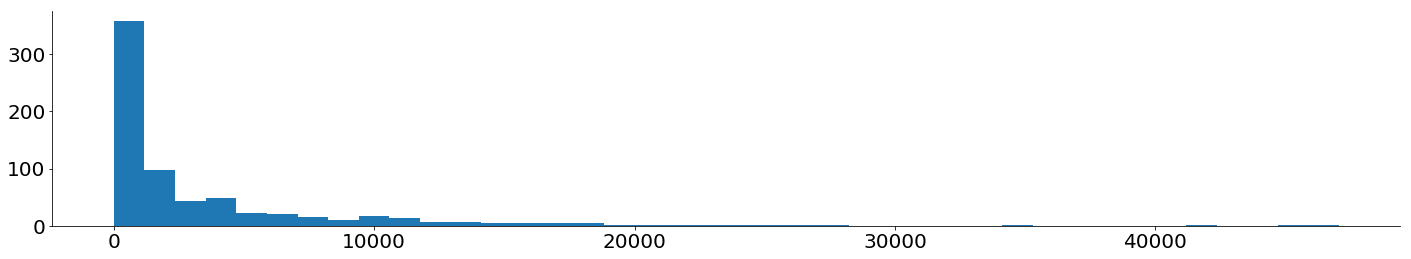

In [141]:
spikes_n = dat['spks'].sum(axis=(1,2))
spikes_mean =  dat['spks'].mean(axis=(1,2))
plt.hist(spikes_n, bins=40)

In [166]:
meaningful_neurons = np.logical_and(spikes_n >= 1000, spikes_n < 30000)
spikes_meaningful = dat['spks'][meaningful_neurons]
meaningful_neurons.shape 

(698,)

## Ploting mean firing rate

In [16]:
dt = dat['bin_size'] # binning at 10 ms
NT = dat['spks'].shape[-1]

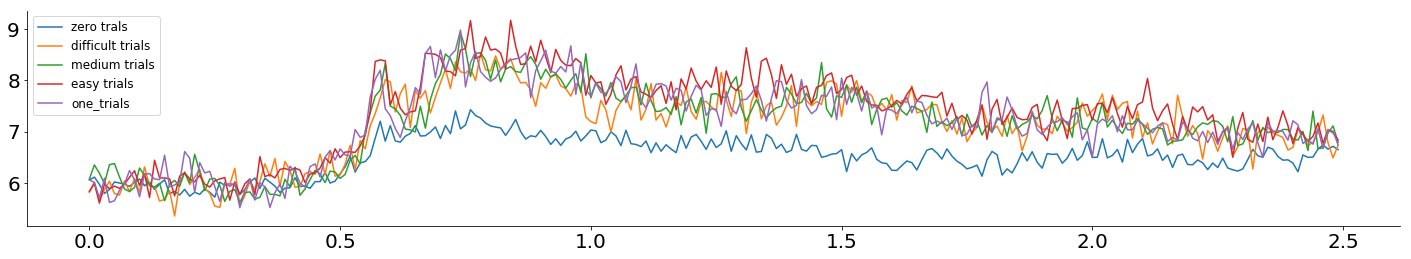

In [175]:
#ax = plt.subplot(1)

plt.plot(dt * np.arange(NT), 1/dt * spikes_meaningful[:, zero_trials].mean(axis=(0,1)))
plt.plot(dt * np.arange(NT), 1/dt * spikes_meaningful[:, difficult_trials].mean(axis=(0,1)))
plt.plot(dt * np.arange(NT), 1/dt * spikes_meaningful[:, medium_trials].mean(axis=(0,1))) 
plt.plot(dt * np.arange(NT), 1/dt * spikes_meaningful[:, easy_trials].mean(axis=(0,1))) 
plt.plot(dt * np.arange(NT), 1/dt * spikes_meaningful[:, one_trials].mean(axis=(0,1))) 


plt.legend(['zero trals', 'difficult trials', 'medium trials', 'easy trials', 'one_trials'], fontsize=12)


In [87]:
# groupings of brain regions
regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"], # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP"," TT"], # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"], # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"], # basal ganglia 
                ["BLA", "BMA", "EP", "EPd", "MEA"] # cortical subplate
                ]

nareas = 4 # only the top 4 regions are in this particular mouse
NN = len(dat['brain_area']) # number of neurons
barea = nareas * np.ones(NN, ) # last one is "other"
for j in range(nareas):
    barea[np.isin(dat['brain_area'], brain_groups[j])] = j # assign a number to each region

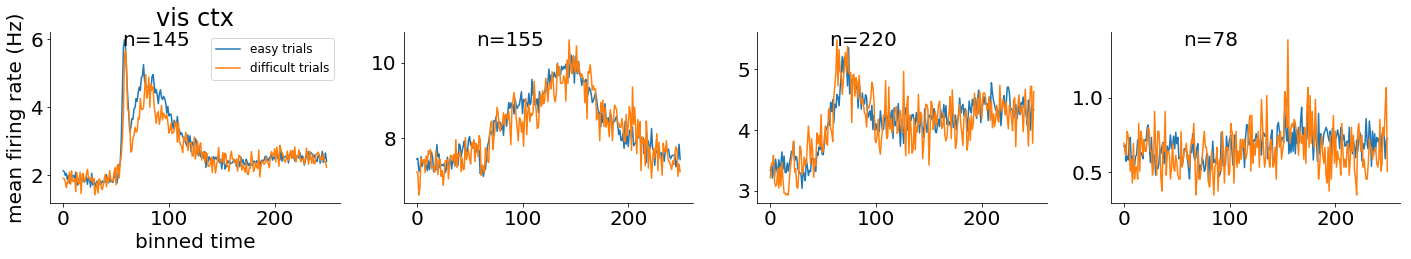

In [90]:
for j in range(nareas):
    ax = plt.subplot(1,nareas,j+1)
    plt.plot(1/dt *  dat['spks'][barea==j][:,easy_trials].mean(axis=(0,1)))
    plt.plot(1/dt *  dat['spks'][barea==j][:,difficult_trials].mean(axis=(0,1)))

    plt.text(.25, .92, 'n=%d'%np.sum(barea==j), transform=ax.transAxes)
    if j==0:
        plt.legend(['easy trials', 'difficult trials'], fontsize=12)
        ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)', title = regions[j])


In [72]:
trials = dt * np.arange(NT), 1/dt * dat['spks']

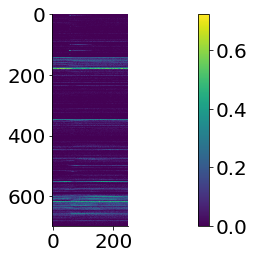

In [43]:
plt.imshow(dat['spks'][:,:,:].mean(axis=1), cmap='viridis')
plt.colorbar()

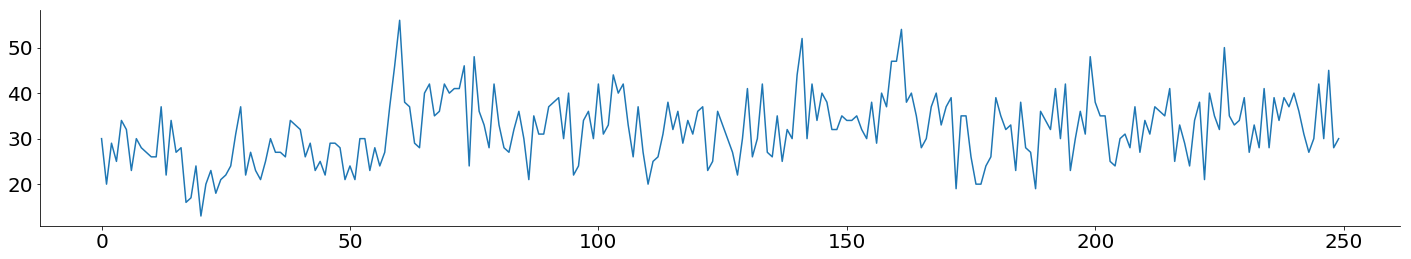

In [41]:
plt.plot(dat['spks'][:,5,:].sum(axis=0))

/home/finc/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


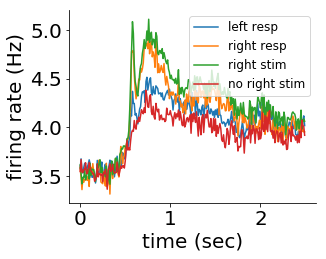

In [15]:
ax = plt.subplot(1,5,1)
response = dat['response'] # right - nogo - left (-1, 0, 1)
vis_right = dat['contrast_right'] # 0 - low - high
vis_left = dat['contrast_left'] # 0 - low - high
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,response>=0].mean(axis=(0,1))) # left responses
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,response<0].mean(axis=(0,1))) # right responses
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,vis_right>0].mean(axis=(0,1))) # stimulus on the right
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,vis_right==0].mean(axis=(0,1))) # no stimulus on the right

plt.legend(['left resp', 'right resp', 'right stim', 'no right stim'], fontsize=12)
ax.set(xlabel  = 'time (sec)', ylabel = 'firing rate (Hz)');

## Groupings of brain regions

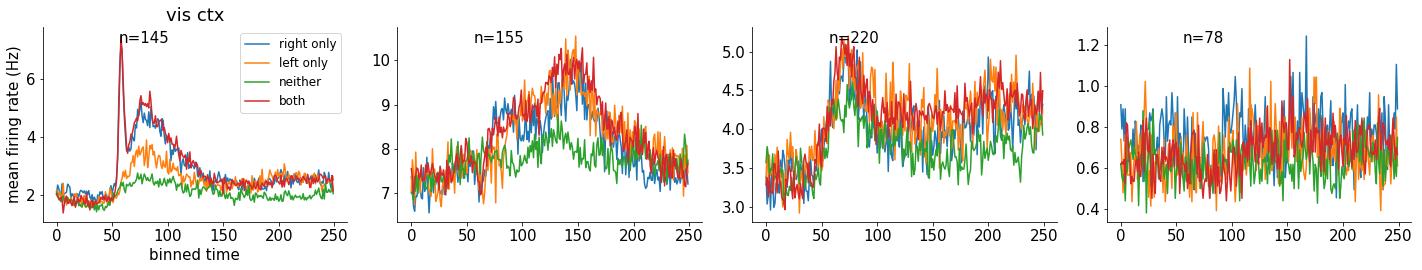

In [18]:
#@title plots by brain region and visual conditions
for j in range(nareas):
    ax = plt.subplot(1,nareas,j+1)
    plt.plot(1/dt *  dat['spks'][barea==j][:,np.logical_and(vis_left==0, vis_right>0)].mean(axis=(0,1)))
    plt.plot(1/dt *  dat['spks'][barea==j][:,np.logical_and(vis_left>0 , vis_right==0)].mean(axis=(0,1)))
    plt.plot(1/dt *  dat['spks'][barea==j][:,np.logical_and(vis_left==0 , vis_right==0)].mean(axis=(0,1)))
    plt.plot(1/dt *  dat['spks'][barea==j][:,np.logical_and(vis_left>0, vis_right>0)].mean(axis=(0,1)))  
    plt.text(.25, .92, 'n=%d'%np.sum(barea==j), transform=ax.transAxes)
    if j==0:
        plt.legend(['right only', 'left only', 'neither', 'both'], fontsize=12)
        ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)', title = regions[j])


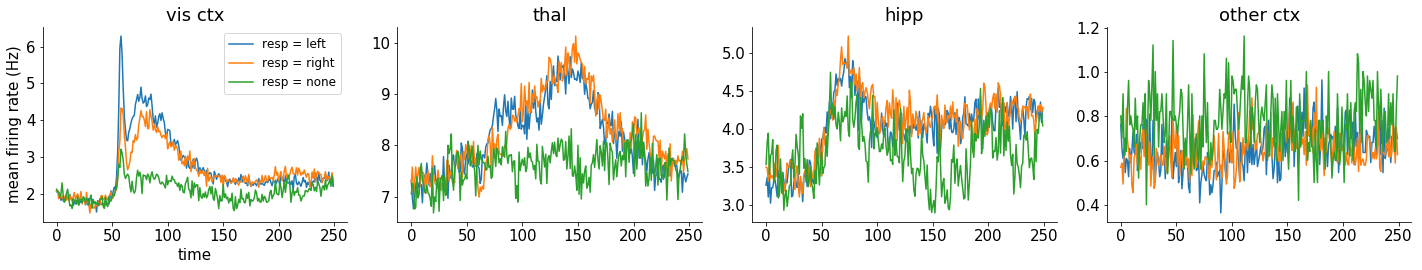

In [20]:
for j in range(nareas):
    ax = plt.subplot(1,nareas,j+1)
    plt.title(regions[j])
    if np.sum(barea==j)==0:
        continue
    plt.plot(1/dt * dat['spks'][barea==j][:,response<0].mean(axis=(0,1)))  
    plt.plot(1/dt * dat['spks'][barea==j][:,response>0].mean(axis=(0,1)))
    plt.plot(1/dt * dat['spks'][barea==j][:,response==0].mean(axis=(0,1)))
    if j==0:
        plt.legend(['resp = left', 'resp = right', 'resp = none'], fontsize=12)
        ax.set(xlabel = 'time', ylabel = 'mean firing rate (Hz)')